In [1]:
import numpy as np
import TransportMaps.Distributions as DIST
import TransportMaps.Distributions.Inference as DISTINF
import TransportMaps.Likelihoods as LKL
import TransportMaps.Maps as MAPS
import matplotlib.pyplot as plt
%matplotlib inline

# Bayesian models

Bayesian models arise naturally in statistical inference problems, where the belief represented by a prior probability distribution need to be updated according to some observations. We can summarize these models as follows.

Let $G:\mathbb{R}^d \rightarrow \mathbb{R}^{d_z}$ be a map, let ${\bf X}\in\mathbb{R}^d$ be a random variable with distribution $\nu_\rho$, representing the **prior** belief on the state of ${\bf X}$, and let ${\bf d}\in\mathbb{R}^{d_y}$ be observations of the output of $G$ for some unknown inputs ${\bf x}\in\mathbb{R}^d$ obtained through the observation model $f:\mathbb{R}^{d_z} \times \mathbb{R}^{d_z}\rightarrow\mathbb{R}^{d_y}$ (invertible in the second input).
This model for the measurements ${\bf d}$ can then be summarized as

$$ {\bf d} = f\left( G({\bf x}), \varepsilon \right) \;, \quad \varepsilon\sim\nu_\mu \;. $$ 

We define the **poserior** distribution $\nu_\pi$ by its density

$$ \pi({\bf x}\vert {\bf Y}={\bf d}) \propto \mu\left( f^{-1}\left(G({\bf x}),{\bf d}\right) \right) \rho({\bf x}) = \overbrace{\mathcal{L}_{\bf d}({\bf x})}^{\rm Likelihood} \underbrace{\rho({\bf x})}_{\rm Prior} \;. $$

In the following we will show how to assemble the distribution $\nu_\pi$. Without loss of generality we will present a Gaussian linear model. More complex model can be defined accordingly.

### Linear Gaussian model

Let us consider here the linear model $G({\bf x}) = {\bf G}{\bf x}$ with additive Gaussian noise $\varepsilon \sim \nu_\mu = \mathcal{N}(0,\Sigma_\mu)$

$$ {\bf d} = {\bf G}{\bf x} + \varepsilon \;. $$


This means that the likelihood is defined as

$$ \mathcal{L}_{\bf d}({\bf x}) = \mu({\bf d} - {\bf G}{\bf x}) \;. $$

Let the prior distribution on ${\bf X}$ be Gaussian, $\nu_\rho \sim \mathcal{N}(m_\rho,\Sigma_\rho)$. 
In particular we consider the following setting: $d=2$, $d_y = d_z = 1$,

$$ {\bf G} = \left[ 5, 3/2 \right] \;, \quad \Sigma_\mu = [1/2] \;,$$
$$ m_\rho = [0, 0]^\top \;, \quad \Sigma_\rho = {\bf I} \;,$$

where ${\bf I}$ is the identity matrix.

In the following we will declare all these pieces and assemble them into the posterior distribution $\nu_\pi$. Let's start declaring the prior distribution $\nu_\rho$.

In [2]:
nurho = DIST.StandardNormalDistribution(2) # nurho.dim = 2

Let us now define the likelihood $\mathcal{L}_{\bf d}$. In practical cases though, the **log-likelihood** is a much better behaved function (numerically), thus we will define $\log\mathcal{L}_{\bf d}$. To do so we use the [AdditiveLogLikelihood](api-TransportMaps-Functionals-Likelihoods.html#TransportMaps.Functionals.Likelihoods.AdditiveLogLikelihood) class, which requires us only to provide the map $G$ (in this case the linear map could be quickly defined through [LinearMap](api-TransportMaps-Maps.html#TransportMaps.Maps.LinearMap)) and the Gaussian noise model.

In [3]:
class LinearMap(MAPS.Map):
    r""" Map :math:`G({\bf x}) = {\bf G} {\bf x}`

    Args:
      G (:class:`ndarray<numpy.ndarray>` [:math:`d_y,d_x`]): linear part (matrix)
    """
    def __init__(self, G):
        super(LinearMap, self).__init__(G.shape[1], G.shape[0])
        self.G = G
    def evaluate(self, x, *args, **kwargs):
        out = self.G.dot(x.T).T # out.shape = (m x dy)
        return out
    def grad_x(self, x, *args, **kwargs):
        out = self.G[nax,:,:]  # out.shape = (m x dy x dx)
        return out
    def hess_x(self, x, *args, **kwargs):
        out = np.zeros((1, self.dim_out, self.dim_in, self.dim_in)) # out.shape = (m x dy x dx x dx)
        return out
# Initialize the linear map
G = np.array([[5., 1.5]])
Gmap = LinearMap(G)
# Initialize the noise model
numu = DIST.GaussianDistribution(np.zeros(1), np.array([[0.5]]))
# Generate some sythetic data
d = Gmap.evaluate( nurho.rvs(1) )[0,:]
# Initialize the log-likelihood
logL = LKL.AdditiveLogLikelihood(d, numu, Gmap)

We are now ready to assemble the posterior distribution $\pi({\bf x}\vert {\bf Y}={\bf d}) \propto \mathcal{L}_{\bf d}({\bf x}) \rho({\bf x}) \;.$

In [4]:
nupi = DISTINF.BayesPosteriorDistribution(logL, nurho)

Let us now plot the prior density agains the (unnormalized) posterior density.

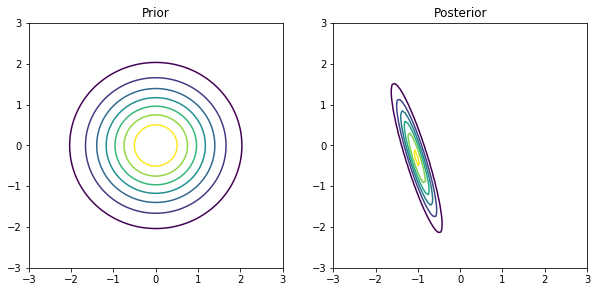

In [5]:
x = np.linspace(-3,3,100)
X,Y = np.meshgrid(x,x)
xx = np.vstack((X.flatten(),Y.flatten())).T # xx.shape is (100^2,2)
prior_pdf = nurho.pdf(xx).reshape(X.shape)
post_pdf = nupi.pdf(xx).reshape(X.shape)
plt.figure(figsize=(10,4.5));
plt.subplot(121); plt.title('Prior');
plt.contour(X,Y,prior_pdf);
plt.subplot(122); plt.title('Posterior');
plt.contour(X,Y,post_pdf);

More complex Bayesian models can be implemented using these simple building blocks and implementing the appropriate map (forward operator) $G$.